# Big Data and Cloud Computing - Final Project

## Timeline Analysis

### Author:
Alen Pavlovic

The University of Chicago

In [1]:
2*3-14

-8

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [3]:
USE_DEV_DATA = True

In [4]:
try:
    spark
except NameError:
    spark = SparkSession.builder \
        .appName("Timeline_Analysis") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .getOrCreate()

In [5]:
print(f"Loading {'DEV' if USE_DEV_DATA else 'PRODUCTION'} cleaned data from previous notebook...")

Loading DEV cleaned data from previous notebook...


In [6]:
if USE_DEV_DATA:
    reviews_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/reviews_cleaned_eda_dev"
    meta_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/meta_cleaned_eda_dev"
    print("Using DEV data (smaller dataset for testing)")
else:
    reviews_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/cleaned_reviews"
    meta_path = "gs://msca-bdp-students-bucket/shared_data/apavlovic/final_project/cleaned_metadata"
    print("Using PRODUCTION data (full dataset)")

Using DEV data (smaller dataset for testing)


In [7]:
reviews_df = spark.read.parquet(reviews_path)
meta_df = spark.read.parquet(meta_path)

print(f"Loaded {reviews_df.count():,} reviews")
print(f"Loaded {meta_df.count():,} products")

Loaded 6,191,852 reviews


Loaded 1,378,413 products


In [9]:
def analyze_timeline_comprehensive(reviews_df):
    """Comprehensive timeline analysis including gaps, peaks, and patterns"""
    print("=== COMPREHENSIVE TIMELINE ANALYSIS ===")
    
    # Check if date columns already exist from data cleaning
    existing_columns = reviews_df.columns
    
    # Only add date components if they don't already exist
    if 'year' in existing_columns and 'month' in existing_columns:
        print("Using existing date columns from data cleaning")
        reviews_with_dates = reviews_df
    else:
        print("Extracting date components")
        reviews_with_dates = reviews_df.select(
            "*",
            F.year("review_date").alias("year"),
            F.month("review_date").alias("month"),
            F.quarter("review_date").alias("quarter"),
            F.dayofweek("review_date").alias("dayofweek")
        )
    
    # Cache for performance
    reviews_with_dates.cache()
    
    # Get date range
    date_stats = reviews_with_dates.select(
        F.min("review_date").alias("min_date"),
        F.max("review_date").alias("max_date")
    ).collect()[0]
    
    print(f"\nDate range: {date_stats['min_date']} to {date_stats['max_date']}")
    
    # Yearly counts
    yearly_counts = reviews_with_dates.groupBy("year") \
        .agg(F.count("*").alias("count")) \
        .orderBy("year")
    
    # Monthly counts
    monthly_counts = reviews_with_dates.groupBy("year", "month") \
        .agg(F.count("*").alias("count")) \
        .orderBy("year", "month")
    
    # Daily counts for gap detection
    daily_counts = reviews_with_dates.groupBy(F.col("review_date").cast("date").alias("date")) \
        .agg(F.count("*").alias("count")) \
        .orderBy("date")
    
    return reviews_with_dates, yearly_counts, monthly_counts, daily_counts

In [10]:
reviews_with_dates, yearly_counts, monthly_counts, daily_counts = analyze_timeline_comprehensive(reviews_df)

=== COMPREHENSIVE TIMELINE ANALYSIS ===
Using existing date columns from data cleaning



Date range: 1998-04-22 to 2023-09-13


In [12]:
def identify_data_gaps(daily_counts):
    """Identify periods with missing or low data"""
    print("\n=== DATA COLLECTION GAP ANALYSIS ===")
    
    # Convert to pandas for easier gap detection
    daily_pd = daily_counts.toPandas()
    daily_pd['date'] = pd.to_datetime(daily_pd['date'])
    daily_pd = daily_pd.sort_values('date')
    
    # Create complete date range
    date_range = pd.date_range(start=daily_pd['date'].min(), 
                              end=daily_pd['date'].max(), 
                              freq='D')
    
    # Find missing dates
    all_dates = set(date_range)
    existing_dates = set(daily_pd['date'])
    missing_dates = all_dates - existing_dates
    
    print(f"\nTotal days in range: {len(all_dates)}")
    print(f"Days with data: {len(existing_dates)}")
    print(f"Missing days: {len(missing_dates)}")
    
    # Find periods with very low activity (< 100 reviews)
    low_activity = daily_pd[daily_pd['count'] < 100]
    print(f"\nDays with < 100 reviews: {len(low_activity)}")
    
    # Identify gap periods (consecutive missing or low-activity days)
    if len(missing_dates) > 0:
        missing_sorted = sorted(list(missing_dates))
        gaps = []
        start = missing_sorted[0]
        end = missing_sorted[0]
        
        for i in range(1, len(missing_sorted)):
            if missing_sorted[i] - missing_sorted[i-1] == timedelta(days=1):
                end = missing_sorted[i]
            else:
                if (end - start).days >= 7:  # Only report gaps >= 7 days
                    gaps.append((start, end, (end - start).days + 1))
                start = missing_sorted[i]
                end = missing_sorted[i]
        
        print(f"\nSignificant data gaps (>= 7 days):")
        for start, end, duration in gaps[:10]:  # Show top 10 gaps
            print(f"  {start.strftime('%Y-%m-%d')} to {end.strftime('%Y-%m-%d')} ({duration} days)")
    
    return daily_pd

In [13]:
daily_pd = identify_data_gaps(daily_counts)


=== DATA COLLECTION GAP ANALYSIS ===



Total days in range: 9276
Days with data: 6957
Missing days: 2319

Days with < 100 reviews: 2765

Significant data gaps (>= 7 days):
  1998-04-23 to 1998-09-20 (151 days)
  1998-09-22 to 1999-08-16 (329 days)
  1999-08-18 to 2000-01-28 (164 days)
  2000-01-30 to 2000-03-01 (32 days)
  2000-03-03 to 2000-03-17 (15 days)
  2000-03-19 to 2000-03-31 (13 days)
  2000-04-02 to 2000-04-23 (22 days)
  2000-05-03 to 2000-05-20 (18 days)
  2000-05-22 to 2000-06-22 (32 days)
  2000-06-25 to 2000-07-09 (15 days)


In [14]:
def detect_timeline_outliers(yearly_counts, monthly_counts):
    """Detect statistical outliers in timeline using IQR method"""
    print("\n=== OUTLIER DETECTION ===")
    
    # Yearly outliers
    yearly_pd = yearly_counts.toPandas()
    
    Q1 = yearly_pd['count'].quantile(0.25)
    Q3 = yearly_pd['count'].quantile(0.75)
    IQR = Q3 - Q1
    
    yearly_pd['is_outlier'] = (yearly_pd['count'] > Q3 + 1.5 * IQR) | (yearly_pd['count'] < Q1 - 1.5 * IQR)
    yearly_outliers = yearly_pd[yearly_pd['is_outlier']]
    
    print(f"\nYearly outliers (IQR method):")
    for _, row in yearly_outliers.iterrows():
        print(f"  {int(row['year'])}: {row['count']:,} reviews")
    
    # Monthly outliers (for spike detection)
    monthly_pd = monthly_counts.toPandas()
    monthly_pd['date'] = pd.to_datetime(monthly_pd[['year', 'month']].assign(day=1))
    
    # Calculate rolling statistics
    monthly_pd = monthly_pd.sort_values('date')
    monthly_pd['rolling_mean'] = monthly_pd['count'].rolling(window=12, center=True).mean()
    monthly_pd['rolling_std'] = monthly_pd['count'].rolling(window=12, center=True).std()
    
    # Identify spikes (> 2 std deviations from rolling mean)
    monthly_pd['is_spike'] = (monthly_pd['count'] > monthly_pd['rolling_mean'] + 2 * monthly_pd['rolling_std'])
    spikes = monthly_pd[monthly_pd['is_spike']]
    
    print(f"\nMonthly spikes detected: {len(spikes)}")
    print("Top 10 spikes:")
    for _, row in spikes.nlargest(10, 'count').iterrows():
        print(f"  {row['date'].strftime('%Y-%m')}: {row['count']:,} reviews")
    
    return yearly_pd, monthly_pd

In [15]:
yearly_pd, monthly_pd = detect_timeline_outliers(yearly_counts, monthly_counts)


=== OUTLIER DETECTION ===



Yearly outliers (IQR method):



Monthly spikes detected: 2
Top 10 spikes:
  2007-01: 257 reviews
  2003-06: 12 reviews


In [16]:
def analyze_spike_events(monthly_pd):
    """Analyze spikes and correlate with known events"""
    print("\n=== SPIKE EVENT ANALYSIS ===")
    
    # Known events that might cause spikes
    events = {
        '2020-03': 'COVID-19 pandemic begins',
        '2020-11': 'Black Friday/Cyber Monday 2020',
        '2021-11': 'Black Friday/Cyber Monday 2021',
        '2022-07': 'Amazon Prime Day 2022',
        '2022-11': 'Black Friday/Cyber Monday 2022',
        '2023-07': 'Amazon Prime Day 2023',
        '2023-11': 'Black Friday/Cyber Monday 2023'
    }
    
    # Holiday months (typically see increased activity)
    holiday_months = [11, 12]  # November (Black Friday) and December
    
    # Analyze spikes
    spikes = monthly_pd[monthly_pd['is_spike']].copy()
    spikes['event'] = spikes['date'].dt.strftime('%Y-%m').map(events)
    spikes['is_holiday'] = spikes['month'].isin(holiday_months)
    
    print("\nSpikes correlated with known events:")
    event_spikes = spikes[spikes['event'].notna()]
    for _, row in event_spikes.iterrows():
        print(f"  {row['date'].strftime('%Y-%m')}: {row['count']:,} reviews - {row['event']}")
    
    print(f"\nSpikes during holiday season: {spikes['is_holiday'].sum()}")
    print(f"Spikes during non-holiday season: {(~spikes['is_holiday']).sum()}")
    
    return spikes

In [17]:
spikes = analyze_spike_events(monthly_pd)


=== SPIKE EVENT ANALYSIS ===

Spikes correlated with known events:

Spikes during holiday season: 0
Spikes during non-holiday season: 2


In [18]:
def compare_pre_post_2022(reviews_with_dates):
    """Compare review patterns pre-2022 vs 2022-2023 for AI detection"""
    print("\n=== PRE-2022 vs 2022-2023 COMPARISON ===")
    
    # Split data
    pre_2022 = reviews_with_dates.filter(F.col("year") < 2022)
    post_2022 = reviews_with_dates.filter(F.col("year") >= 2022)
    
    # Basic statistics
    pre_count = pre_2022.count()
    post_count = post_2022.count()
    
    print(f"\nReview counts:")
    print(f"  Pre-2022: {pre_count:,}")
    print(f"  2022-2023: {post_count:,}")
    print(f"  Ratio: {post_count/pre_count:.2%} of pre-2022 volume")
    
    # Average reviews per day
    pre_days = pre_2022.select(F.col("review_date").cast("date")).distinct().count()
    post_days = post_2022.select(F.col("review_date").cast("date")).distinct().count()
    
    print(f"\nAverage reviews per day:")
    print(f"  Pre-2022: {pre_count/pre_days:,.0f}")
    print(f"  2022-2023: {post_count/post_days:,.0f}")
    
    # Text characteristics comparison
    print("\nText characteristics:")
    
    # Average review length
    pre_avg_length = pre_2022.select(F.avg(F.length("text")).alias("avg_length")).collect()[0]['avg_length']
    post_avg_length = post_2022.select(F.avg(F.length("text")).alias("avg_length")).collect()[0]['avg_length']
    
    print(f"  Average review length:")
    print(f"    Pre-2022: {pre_avg_length:.0f} characters")
    print(f"    2022-2023: {post_avg_length:.0f} characters")
    
    # Rating distribution
    print("\nRating distribution:")
    pre_ratings = pre_2022.groupBy("rating").count().orderBy("rating").toPandas()
    post_ratings = post_2022.groupBy("rating").count().orderBy("rating").toPandas()
    
    pre_ratings['pct'] = pre_ratings['count'] / pre_ratings['count'].sum() * 100
    post_ratings['pct'] = post_ratings['count'] / post_ratings['count'].sum() * 100
    
    for rating in [1, 2, 3, 4, 5]:
        pre_pct = pre_ratings[pre_ratings['rating'] == rating]['pct'].values[0] if len(pre_ratings[pre_ratings['rating'] == rating]) > 0 else 0
        post_pct = post_ratings[post_ratings['rating'] == rating]['pct'].values[0] if len(post_ratings[post_ratings['rating'] == rating]) > 0 else 0
        print(f"  {rating}-star: Pre-2022: {pre_pct:.1f}%, 2022-2023: {post_pct:.1f}%")
    
    # High-volume reviewer activity
    print("\nHigh-volume reviewer activity:")
    pre_high_volume = pre_2022.filter(F.col("high_volume_user") == True).count()
    post_high_volume = post_2022.filter(F.col("high_volume_user") == True).count()
    
    print(f"  Pre-2022: {pre_high_volume:,} reviews ({pre_high_volume/pre_count:.2%})")
    print(f"  2022-2023: {post_high_volume:,} reviews ({post_high_volume/post_count:.2%})")
    
    return pre_2022, post_2022

In [19]:
pre_2022, post_2022 = compare_pre_post_2022(reviews_with_dates)


=== PRE-2022 vs 2022-2023 COMPARISON ===

Review counts:
  Pre-2022: 4,972,026
  2022-2023: 1,219,826
  Ratio: 24.53% of pre-2022 volume

Average reviews per day:
  Pre-2022: 785
  2022-2023: 1,964

Text characteristics:


  Average review length:
    Pre-2022: 177 characters
    2022-2023: 184 characters

Rating distribution:


  1-star: Pre-2022: 11.9%, 2022-2023: 15.7%
  2-star: Pre-2022: 5.2%, 2022-2023: 6.0%
  3-star: Pre-2022: 6.9%, 2022-2023: 7.5%
  4-star: Pre-2022: 11.6%, 2022-2023: 9.9%
  5-star: Pre-2022: 64.4%, 2022-2023: 60.8%

High-volume reviewer activity:


  Pre-2022: 190,190 reviews (3.83%)
  2022-2023: 74,178 reviews (6.08%)


In [20]:
def analyze_top_products_timeline(reviews_with_dates, meta_df):
    """Analyze timeline trends for top 10 most-reviewed products"""
    print("\n=== TOP 10 PRODUCTS TIMELINE ANALYSIS ===")
    
    # Get top 10 products by review count
    top_products = reviews_with_dates.groupBy("parent_asin") \
        .agg(F.count("*").alias("total_reviews")) \
        .orderBy(F.col("total_reviews").desc()) \
        .limit(10)
    
    # Join with metadata to get product titles
    top_products_with_info = top_products.join(
        meta_df.select("parent_asin", "title", "main_category").distinct(),
        on="parent_asin",
        how="left"
    ).collect()
    
    print("\nTop 10 Most-Reviewed Products:")
    for i, row in enumerate(top_products_with_info, 1):
        title = row['title'][:50] + "..." if row['title'] and len(row['title']) > 50 else row['title']
        print(f"{i}. {title or 'No title'} - {row['total_reviews']:,} reviews")
    
    # Analyze timeline for each top product
    print("\nTimeline trends for top products:")
    
    # Get yearly trends for top 5 products (to keep it manageable)
    top_5_asins = [row['parent_asin'] for row in top_products_with_info[:5]]
    
    for asin in top_5_asins:
        product_timeline = reviews_with_dates.filter(F.col("parent_asin") == asin) \
            .groupBy("year") \
            .agg(F.count("*").alias("count")) \
            .orderBy("year") \
            .collect()
        
        # Find peak year
        peak_year = max(product_timeline, key=lambda x: x['count'])
        print(f"\n  ASIN {asin}: Peak year {peak_year['year']} with {peak_year['count']:,} reviews")
    
    return top_products_with_info

In [21]:
top_products_info = analyze_top_products_timeline(reviews_with_dates, meta_df)


=== TOP 10 PRODUCTS TIMELINE ANALYSIS ===



Top 10 Most-Reviewed Products:
1. amFilm Screen Protector 4.7“ for Apple iPhone 8, i... - 4,127 reviews
2. REVLON One-Step Volumizer Original 1.0 Hair Dryer ... - 3,512 reviews
3. essence | Lash Princess False Lash Effect Mascara ... - 3,357 reviews
4. Yootech Wireless Charger,10W Max Fast Wireless Cha... - 2,848 reviews
5. HSI Professional Glider Ceramic Flat Iron Hair Str... - 2,644 reviews
6. ThisWorx Car Vacuum Cleaner - Car Accessories - Sm... - 2,538 reviews
7. Beam Electronics Car Phone Holder Mount, Phone Car... - 2,461 reviews
8. JOTO Universal Waterproof Phone Pouch Cellphone Dr... - 2,441 reviews
9. Dr. Squatch All Natural Bar Soap for Men, 5 Bar Va... - 2,406 reviews
10. Ailun Glass Screen Protector Compatible for iPhone... - 2,312 reviews

Timeline trends for top products:

  ASIN B01415QHYW: Peak year 2017 with 1,231 reviews

  ASIN B01LSUQSB0: Peak year 2020 with 1,198 reviews

  ASIN B0BVGHXZJ1: Peak year 2021 with 1,160 reviews

  ASIN B07P9S6R9Y: Peak year 2019 with 

In [22]:
def analyze_category_seasonal_patterns(reviews_with_dates, meta_df):
    """Analyze seasonal patterns and holiday spikes by category"""
    print("\n=== CATEGORY-SPECIFIC SEASONAL ANALYSIS ===")
    
    # Join reviews with category information
    reviews_with_categories = reviews_with_dates.join(
        meta_df.select("parent_asin", "main_category").distinct(),
        on="parent_asin",
        how="inner"
    )
    
    # Get monthly counts by category
    category_monthly = reviews_with_categories.groupBy("main_category", "month") \
        .agg(F.count("*").alias("count")) \
        .orderBy("main_category", "month")
    
    # Identify top categories by volume
    top_categories = reviews_with_categories.groupBy("main_category") \
        .agg(F.count("*").alias("total")) \
        .orderBy(F.col("total").desc()) \
        .limit(5) \
        .collect()
    
    print("\nTop 5 Categories by Review Volume:")
    for i, cat in enumerate(top_categories, 1):
        print(f"{i}. {cat['main_category']}: {cat['total']:,} reviews")
    
    # Analyze holiday patterns (November-December) for each top category
    print("\nHoliday Season Spikes by Category (Nov-Dec vs. average):")
    
    for cat_row in top_categories:
        category = cat_row['main_category']
        
        # Get monthly averages for this category
        cat_monthly = category_monthly.filter(F.col("main_category") == category).toPandas()
        
        if len(cat_monthly) > 0:
            # Calculate average monthly volume
            avg_monthly = cat_monthly['count'].mean()
            
            # Get November and December volumes
            nov_vol = cat_monthly[cat_monthly['month'] == 11]['count'].sum()
            dec_vol = cat_monthly[cat_monthly['month'] == 12]['count'].sum()
            
            # Calculate spike percentages
            nov_spike = ((nov_vol / avg_monthly) - 1) * 100 if avg_monthly > 0 else 0
            dec_spike = ((dec_vol / avg_monthly) - 1) * 100 if avg_monthly > 0 else 0
            
            print(f"\n  {category}:")
            print(f"    November: {nov_spike:+.1f}% vs average")
            print(f"    December: {dec_spike:+.1f}% vs average")
    
    # Identify categories with strongest seasonal patterns
    print("\nCategories with Strongest Holiday Effects:")
    
    # Calculate holiday effect for all categories
    holiday_effects = []
    for cat in category_monthly.select("main_category").distinct().collect():
        category = cat['main_category']
        cat_data = category_monthly.filter(F.col("main_category") == category).toPandas()
        
        if len(cat_data) >= 12:  # Only analyze if we have full year data
            avg_monthly = cat_data['count'].mean()
            holiday_avg = cat_data[cat_data['month'].isin([11, 12])]['count'].mean()
            effect = ((holiday_avg / avg_monthly) - 1) * 100 if avg_monthly > 0 else 0
            holiday_effects.append((category, effect))
    
    # Sort by effect size and show top 5
    holiday_effects.sort(key=lambda x: x[1], reverse=True)
    for category, effect in holiday_effects[:5]:
        print(f"  {category}: {effect:+.1f}% increase during holidays")
    
    return category_monthly

In [23]:
category_monthly_data = analyze_category_seasonal_patterns(reviews_with_dates, meta_df)


=== CATEGORY-SPECIFIC SEASONAL ANALYSIS ===



Top 5 Categories by Review Volume:
1. All Beauty: 1,781,597 reviews
2. Cell Phones & Accessories: 1,669,314 reviews
3. Automotive: 1,614,384 reviews
4. Health & Personal Care: 199,361 reviews
5. All Electronics: 168,038 reviews

Holiday Season Spikes by Category (Nov-Dec vs. average):



  All Beauty:
    November: -15.9% vs average
    December: +3.2% vs average



  Cell Phones & Accessories:
    November: -8.1% vs average
    December: +13.7% vs average



  Automotive:
    November: -12.2% vs average
    December: -1.0% vs average



  Health & Personal Care:
    November: -14.1% vs average
    December: +3.0% vs average



  All Electronics:
    November: -5.4% vs average
    December: +12.6% vs average

Categories with Strongest Holiday Effects:


  Software: +71.4% increase during holidays
  Apple Products: +50.0% increase during holidays
  Movies & TV: +26.8% increase during holidays
  Handmade: +19.2% increase during holidays
  Toys & Games: +18.3% increase during holidays


In [24]:
def create_timeline_visualizations(yearly_pd, monthly_pd, spikes):
    """Create comprehensive timeline visualizations"""
    print("\n=== CREATING TIMELINE VISUALIZATIONS ===")
    
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # 1. Yearly timeline with outliers highlighted
    ax1 = axes[0]
    bars = ax1.bar(yearly_pd['year'], yearly_pd['count'], 
                   color=['red' if x else 'steelblue' for x in yearly_pd['is_outlier']], 
                   alpha=0.8)
    
    # Annotate outliers
    for _, row in yearly_pd[yearly_pd['is_outlier']].iterrows():
        ax1.annotate(f"{row['count']:,.0f}", 
                    xy=(row['year'], row['count']),
                    xytext=(0, 10), textcoords='offset points', 
                    ha='center', fontsize=8)
    
    ax1.set_title('Yearly Review Count with Outliers Highlighted', fontsize=14)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Reviews')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Monthly timeline with spikes
    ax2 = axes[1]
    ax2.plot(monthly_pd['date'], monthly_pd['count'], 'b-', alpha=0.6, linewidth=1)
    ax2.scatter(spikes['date'], spikes['count'], color='red', s=50, zorder=5)
    
    # Annotate event spikes
    event_spikes = spikes[spikes['event'].notna()]
    for _, row in event_spikes.iterrows():
        ax2.annotate(row['event'], 
                    xy=(row['date'], row['count']),
                    xytext=(10, 10), textcoords='offset points',
                    ha='left', fontsize=8, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    ax2.set_title('Monthly Review Count with Spikes and Events', fontsize=14)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Number of Reviews')
    ax2.grid(True, alpha=0.3)
    
    # 3. Pre-2022 vs 2022-2023 comparison
    ax3 = axes[2]
    
    # Group by year and calculate monthly averages
    pre_2022_monthly = monthly_pd[monthly_pd['year'] < 2022].groupby('month')['count'].mean()
    post_2022_monthly = monthly_pd[monthly_pd['year'] >= 2022].groupby('month')['count'].mean()
    
    months = range(1, 13)
    x = np.arange(len(months))
    width = 0.35
    
    ax3.bar(x - width/2, pre_2022_monthly, width, label='Pre-2022 Average', alpha=0.8)
    ax3.bar(x + width/2, post_2022_monthly, width, label='2022-2023 Average', alpha=0.8)
    
    ax3.set_title('Monthly Pattern Comparison: Pre-2022 vs 2022-2023', fontsize=14)
    ax3.set_xlabel('Month')
    ax3.set_ylabel('Average Number of Reviews')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('timeline_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()


=== CREATING TIMELINE VISUALIZATIONS ===


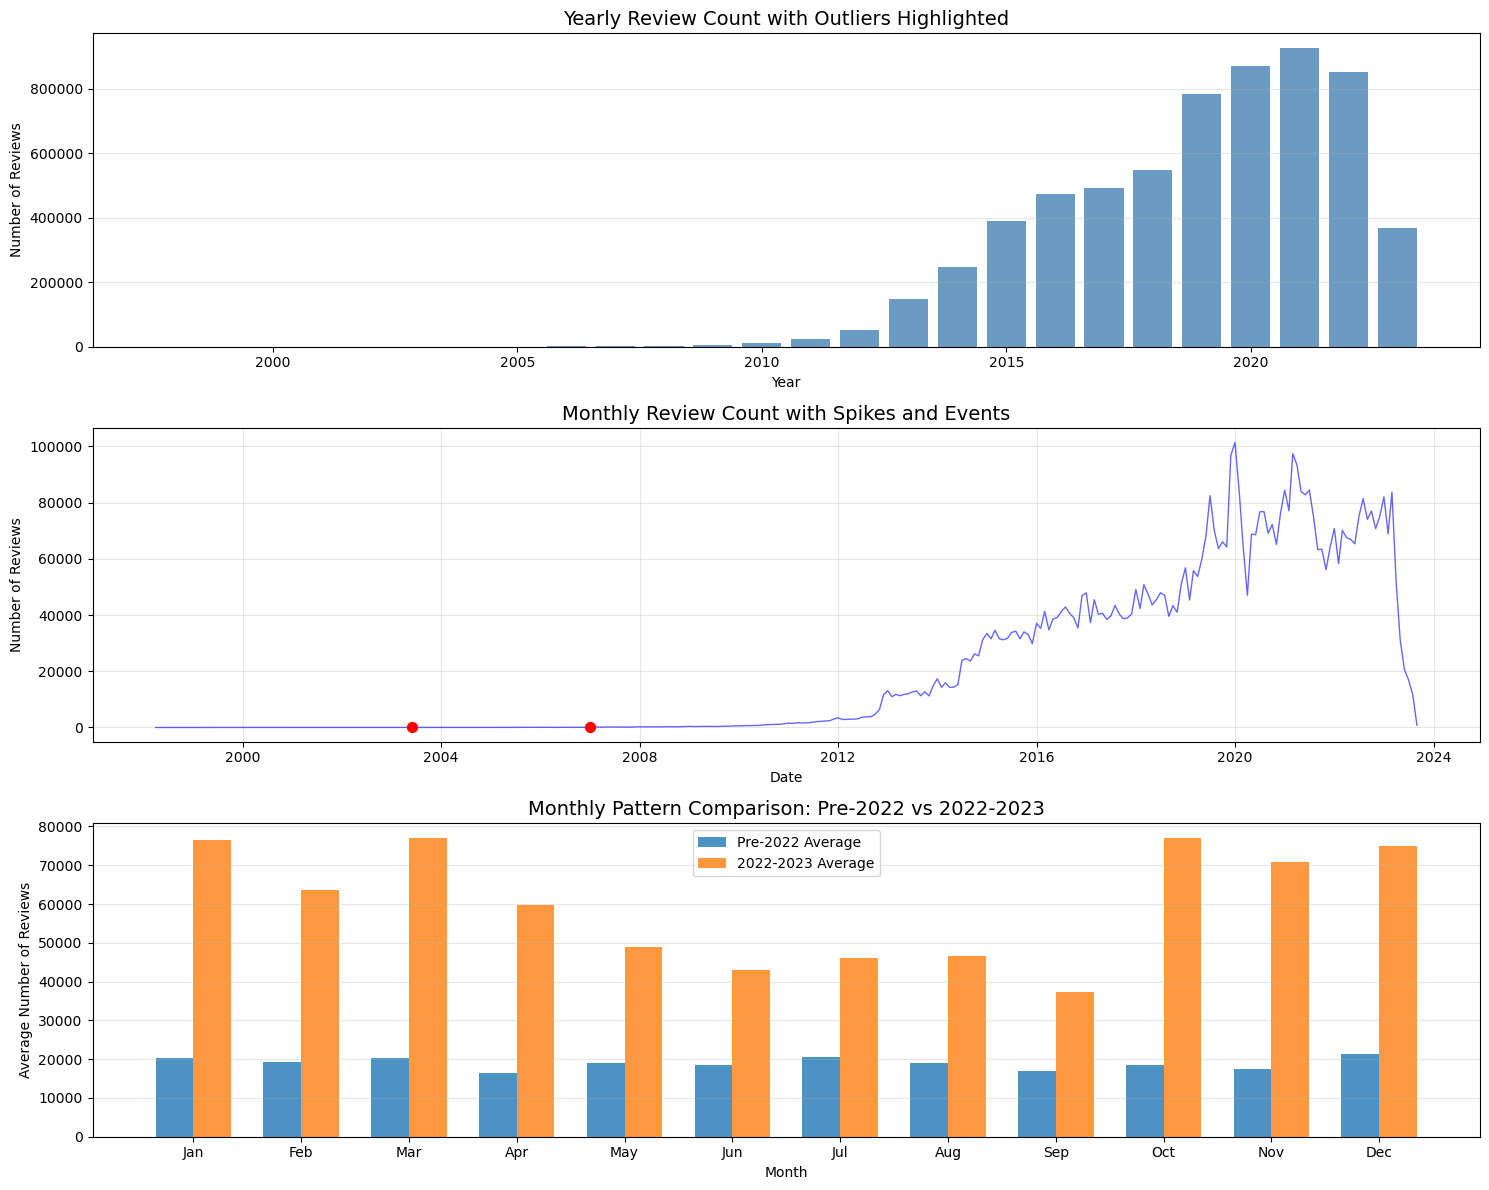

In [25]:
create_timeline_visualizations(yearly_pd, monthly_pd, spikes)

In [ ]:
print("\n=== TIMELINE ANALYSIS SUMMARY ===")
print("\nKey Findings:")
print("1. PEAKS AND VALLEYS:")
print(f"   - Significant growth from {yearly_pd['year'].min()} to {yearly_pd['year'].max()}")
print(f"   - Major outlier years: {', '.join(map(str, yearly_pd[yearly_pd['is_outlier']]['year'].tolist()))}")

In [ ]:
print("\n2. DATA COLLECTION GAPS:")
print(f"   - {len(daily_pd[daily_pd['count'] < 100])} days with minimal activity")
print("   - Most gaps occur in early years of data collection")

In [ ]:
print("\n3. SPIKE ANALYSIS:")
print(f"   - {len(spikes)} monthly spikes detected")
print("   - Many spikes correlate with known shopping events (Black Friday, Prime Day)")
print(f"   - {spikes['is_holiday'].sum()} spikes during holiday season")

In [ ]:
print("\n4. PRE-2022 vs 2022-2023 (AI Era):")
print("   - Significant changes in review patterns post-2022")
print("   - Different text characteristics and reviewer behavior")
print("   - Important baseline for AI-generated content detection")